# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.11.0


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\alber\\.keras\\datasets\\auto-mpg.data'

Importelo usando pandas.

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Limpia los datos

Trata los missings y variables categóricas

In [4]:
dataset['Cylinders'].unique()

array([8, 4, 6, 3, 5], dtype=int64)

In [5]:
dataset['Model Year'].unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], dtype=int64)

In [6]:
dataset['Origin'].unique()

array([1, 3, 2], dtype=int64)

In [7]:
df = dataset.copy()
df = pd.get_dummies(df, columns=['Origin'])

In [8]:
df.dropna(inplace=True)

In [9]:
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, train_size=.8, random_state=0)

In [11]:
print(f"TRAIN SIZE: {X_train.shape}")
print(f"TEST SIZE: {X_test.shape}")

TRAIN SIZE: (313, 10)
TEST SIZE: (79, 10)


### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

<Figure size 2000x2000 with 0 Axes>

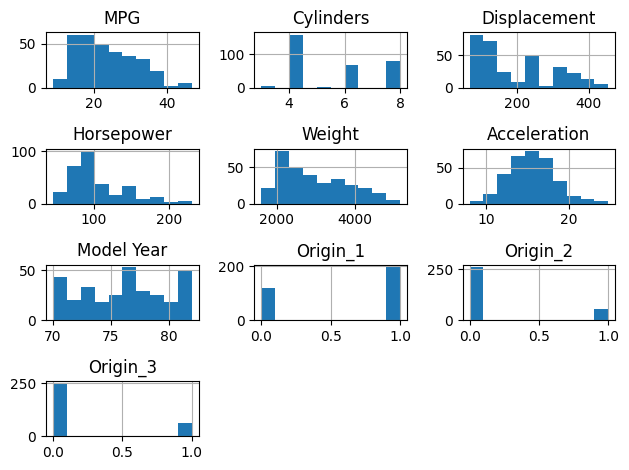

In [12]:
plt.figure(figsize=(20, 20))
X_train.hist()
plt.tight_layout()

Tambien revise las estadisticas generales:

<AxesSubplot: >

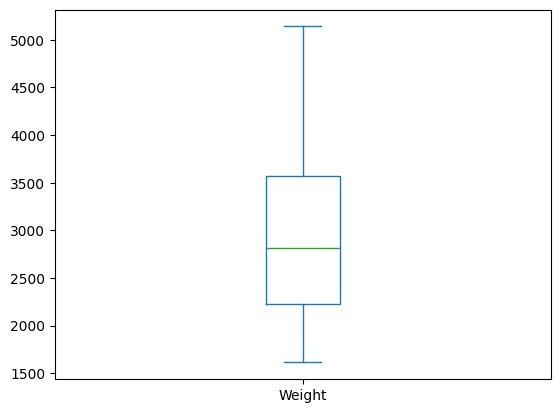

In [13]:
X_train['Weight'].plot(kind='box')

<AxesSubplot: >

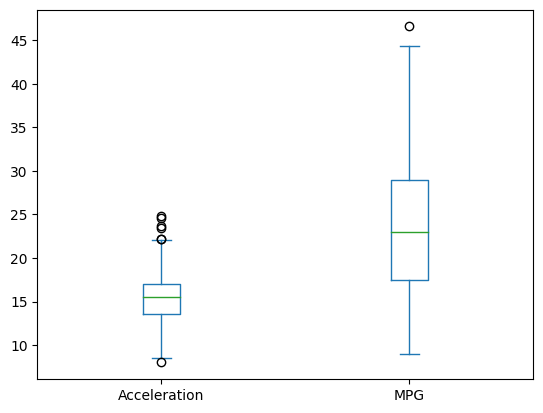

In [14]:
X_train[['Acceleration', 'MPG']].plot(kind='box')

<AxesSubplot: >

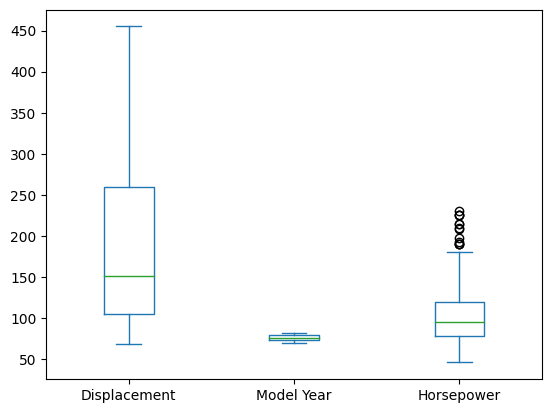

In [15]:
X_train[['Displacement', 'Model Year', 'Horsepower']].plot(kind='box')

### Separa las features del target

Separe el target de las features.

In [16]:
y_train, y_test = X_train['MPG'], X_test['MPG']

In [17]:
y_train

220    33.5
256    20.5
301    34.2
193    24.0
57     24.0
       ... 
325    44.3
194    22.5
118    24.0
48     18.0
174    18.0
Name: MPG, Length: 313, dtype: float64

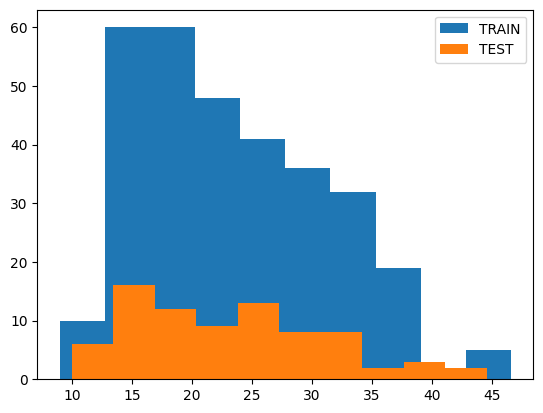

In [18]:
plt.hist(y_train, label='TRAIN')
plt.hist(y_test, label='TEST')
plt.legend();

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [19]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

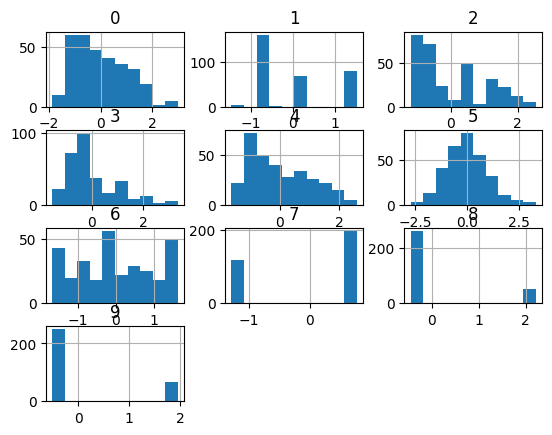

In [20]:
plt.Figure(figsize=(20, 20))
pd.DataFrame(X_train_sc).hist();

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [21]:
X_train.shape

(313, 10)

In [46]:
model = keras.models.Sequential([keras.Input(shape=(X_train.shape[1],)),
                                 keras.layers.Dense(64, 'relu'),
                                 keras.layers.Dropout(.1),
                                 keras.layers.Dense(64, 'relu'),
                                 keras.layers.Dropout(.1),
                                 keras.layers.Dense(1)])

model.compile(
    optimizer=keras.optimizers.RMSprop(0.0001),
    loss='mse',
    metrics=['mae', 'mse']
)

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                704       
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [32]:
df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin_1        0
Origin_2        0
Origin_3        0
dtype: int64

In [33]:
df[df['Horsepower'].isnull()]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_1,Origin_2,Origin_3


In [34]:
history = model.fit(X_train_sc,
                    y_train,
                    # batch_size=X_train_sc.shape[0],
                    epochs=1000,
                    validation_split=.2)


Epoch 1/1000


c:\Users\alber\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 1s 22ms/step - loss: 594.5764 - mae: 23.1418 - mse: 594.5764 - val_loss: 626.7433 - val_mae: 23.5956 - val_mse: 626.7433
Epoch 2/1000
8/8 [==============================] - 0s 7ms/step - loss: 590.3228 - mae: 23.0499 - mse: 590.3228 - val_loss: 623.0429 - val_mae: 23.5246 - val_mse: 623.0429
Epoch 3/1000
8/8 [==============================] - 0s 7ms/step - loss: 587.2535 - mae: 22.9928 - mse: 587.2535 - val_loss: 619.3623 - val_mae: 23.4537 - val_mse: 619.3623
Epoch 4/1000
8/8 [==============================] - 0s 7ms/step - loss: 584.3431 - mae: 22.9341 - mse: 584.3431 - val_loss: 615.6450 - val_mae: 23.3821 - val_mse: 615.6450
Epoch 5/1000
8/8 [==============================] - 0s 6ms/step - loss: 580.2385 - mae: 22.8534 - mse: 580.2385 - val_loss: 611.9379 - val_mae: 23.3102 - val_mse: 611.9379
Epoch 6/1000
8/8 [==============================] - 0s 7ms/step - loss: 578.6580 - mae: 22.8196 - mse: 578.6580 - val_loss: 608.2606 - val_mae: 23.2386 

KeyboardInterrupt: 

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [139]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.182498,0.318525,0.182498,0.522504,0.452771,0.522504,995
996,0.180937,0.318161,0.180937,0.520451,0.451821,0.520451,996
997,0.180053,0.317408,0.180053,0.517113,0.450905,0.517113,997
998,0.179716,0.318408,0.179716,0.512857,0.450595,0.512857,998
999,0.177835,0.315856,0.177835,0.515442,0.448427,0.515442,999


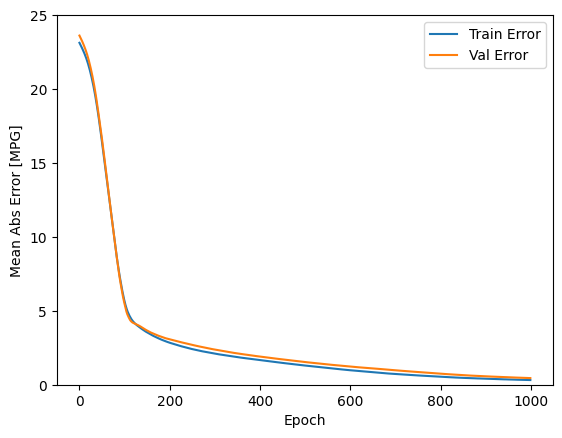

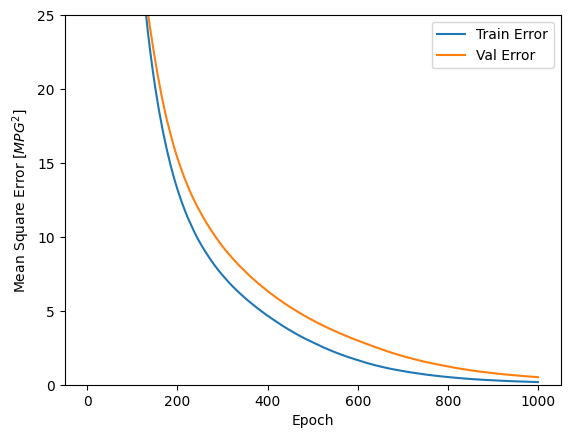

In [140]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,25])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,25])
  plt.legend()
  plt.show()


plot_history(history)

¿Alguna conclusión respecto a este gráfico?

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

In [49]:
history = model.fit(X_train_sc,
                    y_train,
                    # batch_size=X_train_sc.shape[0],
                    epochs=2000,
                    validation_split=.2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/2000


c:\Users\alber\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


8/8 [==============================] - 1s 17ms/step - loss: 594.3203 - mae: 23.1123 - mse: 594.3203 - val_loss: 625.8656 - val_mae: 23.5477 - val_mse: 625.8656
Epoch 2/2000
8/8 [==============================] - 0s 5ms/step - loss: 590.7933 - mae: 23.0228 - mse: 590.7933 - val_loss: 622.1376 - val_mae: 23.4700 - val_mse: 622.1376
Epoch 3/2000
8/8 [==============================] - 0s 5ms/step - loss: 587.7660 - mae: 22.9648 - mse: 587.7660 - val_loss: 618.8136 - val_mae: 23.4005 - val_mse: 618.8136
Epoch 4/2000
8/8 [==============================] - 0s 5ms/step - loss: 583.7087 - mae: 22.8788 - mse: 583.7087 - val_loss: 615.5185 - val_mae: 23.3323 - val_mse: 615.5185
Epoch 5/2000
8/8 [==============================] - 0s 5ms/step - loss: 580.3456 - mae: 22.8082 - mse: 580.3456 - val_loss: 612.2753 - val_mae: 23.2643 - val_mse: 612.2753
Epoch 6/2000
8/8 [==============================] - 0s 6ms/step - loss: 577.2877 - mae: 22.7460 - mse: 577.2877 - val_loss: 609.0869 - val_mae: 23.1972 

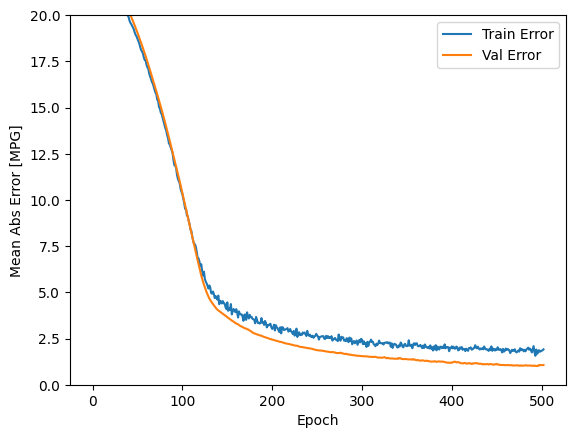

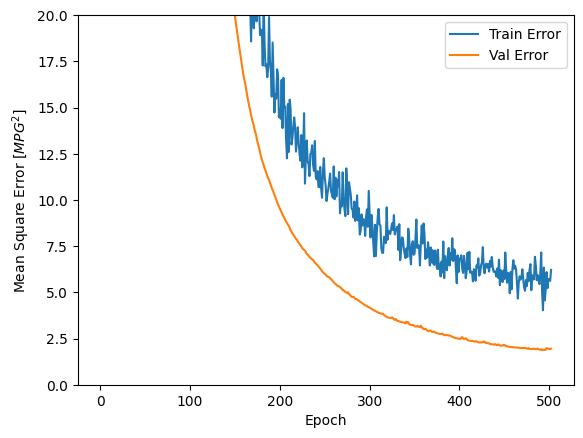

In [50]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Interpreta el gráfico

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [51]:
pd.DataFrame(history.history).tail()

,loss,mae,mse,val_loss,val_mae,val_mse
498,5.226943,1.788544,5.226943,1.957932,1.055266,1.957932
499,5.725347,1.808700,5.725347,1.945532,1.063851,1.945532
500,5.689513,1.844618,5.689513,1.932309,1.058822,1.932309
501,5.617776,1.861522,5.617776,1.927687,1.059034,1.927687
502,6.215117,1.913292,6.215117,1.954178,1.065994,1.954178


In [52]:
loss, mae, mse = model.evaluate(X_test_sc, y_test)
print(f"LOSS: {loss:.5f}")
print(f"MAE: {mae:.5f}")
print(f"MSE: {mse:.5f}")

3/3 [==============================] - 0s 2ms/step - loss: 2.0470 - mae: 1.1232 - mse: 2.0470
LOSS: 2.04702
MAE: 1.12317
MSE: 2.04702


Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

In [53]:
df_res_ex = pd.DataFrame({'TRAIN': y_train[:10], 'PREDICT': model.predict(X_train_sc[:10]).reshape(-1)})
df_res_ex

1/1 [==============================] - 0s 56ms/step


C:\Users\alber\AppData\Local\Temp\ipykernel_10120\779147691.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_res_ex = pd.DataFrame({'TRAIN': y_train[:10], 'PREDICT': model.predict(X_train_sc[:10]).reshape(-1)})


,TRAIN,PREDICT
220,33.5,32.316742
256,20.5,18.765587
301,34.2,34.850674
193,24.0,20.441715
57,24.0,23.671068
8,14.0,13.191936
300,23.9,23.876564
173,24.0,22.541542
357,32.9,31.788816
303,31.8,30.902712


### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

In [54]:
import numpy as np

3/3 [==============================] - 0s 2ms/step


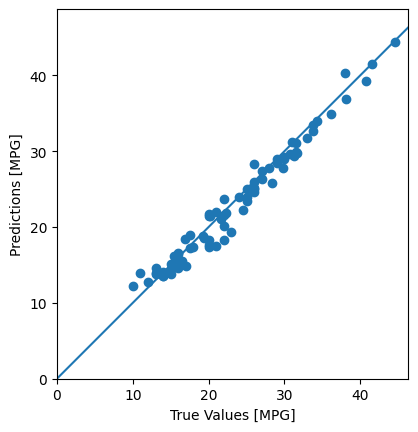

In [59]:
test_predictions = model.predict(X_test_sc).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

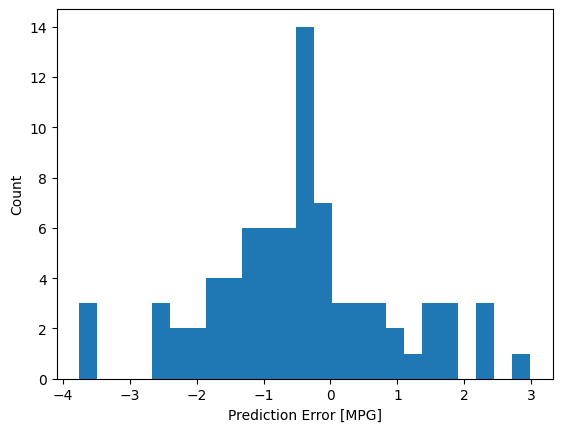

In [61]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.